Performing descriptive statistics for the derived variables from the new dataset

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

In [5]:
df1 = pd.read_csv("D:\DDP\preprocessed data\preprocessed_chkpt_0-100000.csv", index_col=0)
df2 = pd.read_csv("D:\DDP\preprocessed data\preprocessed_chkpt_100000-200000.csv", index_col=0)
df3 = pd.read_csv("D:\DDP\preprocessed data\preprocessed_chkpt_200000-300000.csv", index_col=0)
df4 = pd.read_csv("D:\DDP\preprocessed data\preprocessed_chkpt_300000-400000.csv", index_col=0)
df5 = pd.read_csv("D:\DDP\preprocessed data\preprocessed_chkpt_400000-494696.csv", index_col=0)

df = pd.concat([df1, df2, df3, df4, df5])
df = df.drop_duplicates()

In [31]:
df.columns

Index(['household_id', 'loan_period', 'active_loans_count',
       'opened_loans_count', 'closed_loans_count', 'churn',
       'outstanding_loans_end', 'dpd', 'deliquency', 'income_quarter',
       'expense_quarter', 'instmt_quarter', 'debt_service_ratio',
       'outstanding_loans_begining', 'churn_prev_five_max',
       'churn_prev_three_max', 'churn_average_prev_five',
       'churn_median_prev_five', 'churn_average_prev_eight',
       'churn_median_prev_eight', 'outstanding_loans_delta',
       'debt_service_delta', 'cross_bor', 'contributor_number'],
      dtype='object')

Let's find out the distribution of the number of quarters for each household

In [39]:
df['year'] = df['loan_period'].apply(lambda x: x[:4])

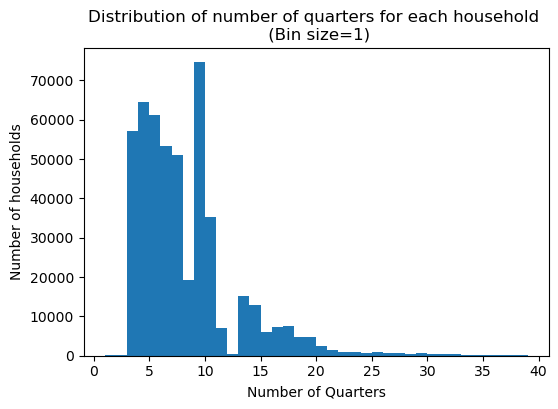

count    494696.000000
mean          7.825834
std           4.664763
min           1.000000
25%           5.000000
50%           7.000000
75%           9.000000
max          53.000000
Name: loan_period, dtype: float64

In [50]:
quarter_counts = df.groupby(['household_id']).loan_period.count()
plt.figure(figsize=(6,4))
plt.hist(quarter_counts, bins = np.arange(1,40))
plt.title('Distribution of number of quarters for each household \n (Bin size=1)')
plt.xlabel('Number of Quarters')
plt.ylabel('Number of households')
plt.show()

quarter_counts.describe()

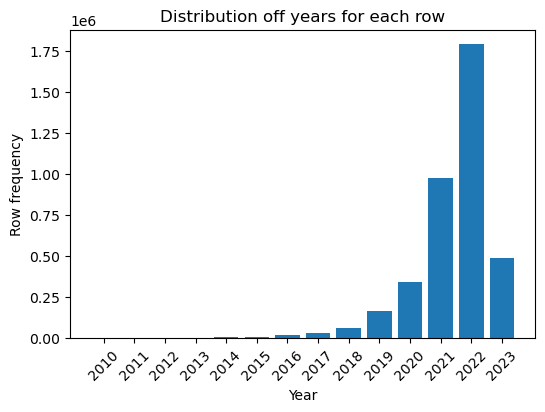

In [53]:
plt.figure(figsize = (6, 4))
temp = df.year.value_counts().sort_index()
plt.bar(temp.index, temp.values)
plt.xlabel('Year')
plt.ylabel('Row frequency')
plt.xticks(rotation = 45)
plt.title('Distribution off years for each row')
plt.show()

Distribution of features used for time series modelling

In [56]:
ts_cols = ['active_loans_count',
       'opened_loans_count', 'closed_loans_count', 'churn',
       'outstanding_loans_end','dpd','cross_bor','outstanding_loans_begining','income_quarter',
       'expense_quarter']
df_ts = df[ts_cols]
df_ts.describe()

,active_loans_count,opened_loans_count,closed_loans_count,churn,outstanding_loans_end,dpd,cross_bor,outstanding_loans_begining,income_quarter,expense_quarter
count,3.871409e+06,3.871409e+06,3.871409e+06,3.871409e+06,3.871409e+06,3.871409e+06,3871409.0,3.871409e+06,3.871409e+06,3.871409e+06
mean,9.040820e-01,1.390646e-01,5.087037e-03,2.351599e-03,1.043147e+00,6.437972e+07,1.0,9.091690e-01,1.277175e+06,9.336449e+03
std,4.071177e-01,3.524488e-01,7.240504e-02,4.883457e-02,2.339482e-01,2.455680e+08,0.0,4.039060e-01,7.975056e+06,1.020783e+04
min,-3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.0,1.000000e+00,7.800000e+04,5.125000e+03
50%,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.0,1.000000e+00,1.320000e+05,8.400000e+03
75%,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.400000e+01,1.0,1.000000e+00,1.940000e+05,1.220000e+04
max,1.400000e+01,1.100000e+01,6.000000e+00,4.000000e+00,1.400000e+01,2.000000e+09,1.0,1.400000e+01,1.080000e+09,7.436875e+06


We select those households which have at least minimum threshold number of quarters for analysis. Also we ignore first few quarters which may have inconsistencies.

In [6]:
threshold_qtr = 10 # minmum threshold number of quarters. we will consider only households with number of quarters equal to or more than this value for analysis
q_ignore = 2 # first "q_ignore" quarters will be ignored
q_consider = 7 # (q_ignore + 1)'th till (q_ignore + q_consider)'th quarters will be considered


temp = df.groupby('household_id')['loan_period'].count()
subset_hids = temp[temp.values > threshold_qtr].index

In [62]:
df_subset = pd.DataFrame()

for hid in tqdm(subset_hids):
    temp = df[df.household_id == hid] 
    temp = temp.sort_values(by='loan_period')
    temp = temp.loc[q_ignore : q_ignore+q_consider-1]
    df_subset = pd.concat([df_subset, temp])

100%|██████████| 78010/78010 [42:30<00:00, 30.59it/s]


In [2]:
#df_subset.to_csv("D:\DDP\preprocessed data\preprocessed_subset_10_2_7.csv")
df_subset = pd.read_csv("D:\DDP\preprocessed data\preprocessed_subset_10_2_7.csv")

Calculating the average number of changes in 'q_consider' quarters for each derived variable. 

In [7]:
dpd_last_quarter_list = []
abs_sum_change = dict()

for hid in tqdm(subset_hids):
    temp = df_subset[df_subset.household_id == hid]
    dpd_last_quarter_list.append(temp['dpd'].tolist()[-1])
    for col in ts_cols:
        if col in abs_sum_change:
            abs_sum_change[col]  += (temp[col].diff()[1:]!=0).sum()
        else:
            abs_sum_change[col] = (temp[col].diff()[1:]!=0).sum()

  0%|          | 0/78010 [00:00<?, ?it/s]


NameError: name 'ts_cols' is not defined

Distribution of days past due in the last quarter

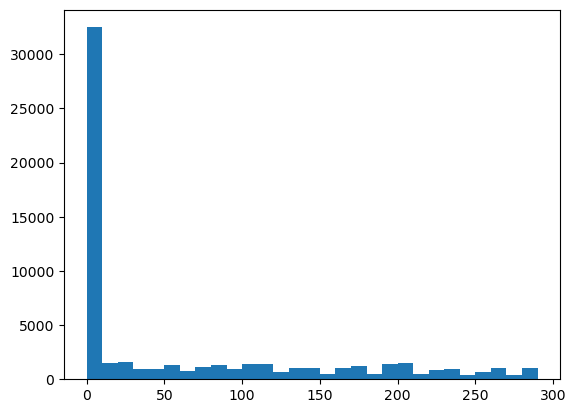

In [124]:
plt.hist(dpd_last_quarter_list, bins=np.arange(0,300,10))
plt.show()

In [121]:
# we can see that around 40% of the rows have dpd value as 0
len(dpd_last_quarter_list), (np.array(dpd_last_quarter_list) == 0).sum()

(78010, 31501)

In [12]:
# general deliquency distribution for the whole dataset is below (ignoring quarters)
# little over 20% has deliquent label
df['deliquency'].sum() , df.shape[0]

(1025463, 3871409)

Let's find out how many households have been deliquent in at least one quarter

In [19]:
# 30 lakh out of 38 lakh households have been deliquent in at least one quarter 
# further sanity checks requireds

temp = df.groupby('household_id')['deliquency'].apply(max).reset_index()
temp[temp.deliquency == True].shape

(303997, 2)

Even better, let's see the distribution of households (number of households) by number of deliquent quarters

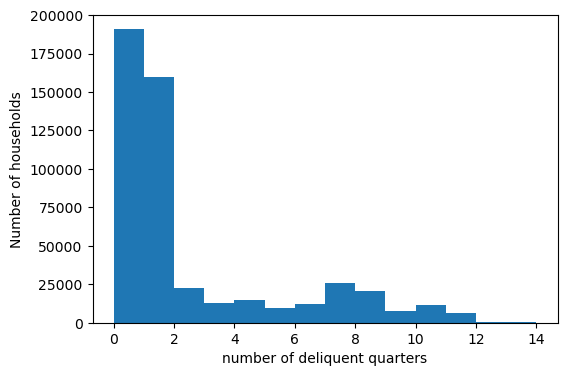

In [22]:
# Distribution of households w.r.t number of deliquent quarters
# Observation: There are exceedingly many households with 0 and 1 deliquent quarters. 
# We need to investaigate why many households have one deliquent quarter

temp = df.groupby('household_id')['deliquency'].apply(sum).reset_index()
plt.figure(figsize = (6, 4))
plt.hist(temp['deliquency'], bins=range(0,15,1))
plt.xlabel('number of deliquent quarters')
plt.ylabel('Number of households')
plt.show()

Are there some years where deliquency was more or less compared to others due to the impact of COVID-19? Let's plot the distribution of deliquent households by quarter. We also plot the fraction of deliquent households by quarter. 

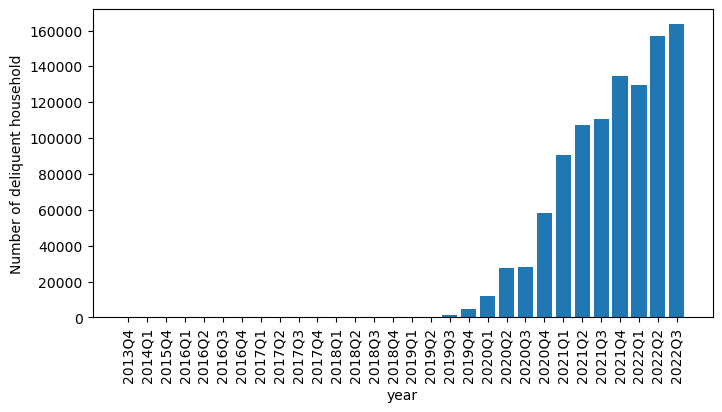

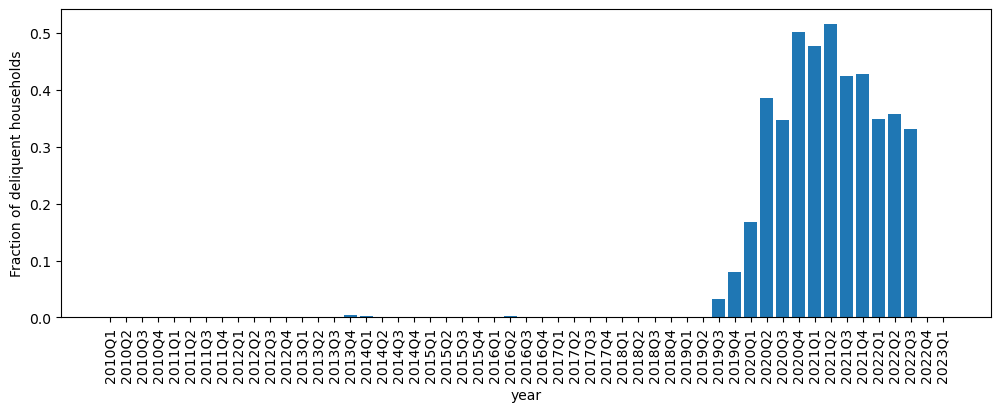

In [63]:
df_deliquent = df[df.deliquency == True]
df_del_qtr = df_deliquent.groupby('loan_period')['household_id'].apply(lambda x: len(np.unique(x))).sort_index().reset_index()
df_del_qtr.columns = ['loan_period', 'deliquent_households']
df_qtr = df.groupby('loan_period')['household_id'].apply(lambda x: len(np.unique(x))).sort_index().reset_index()
df_qtr.columns = ['loan_period', 'households']

plt.figure(figsize=(8,4))
plt.bar(df_del_qtr.loan_period, df_del_qtr.deliquent_households)
plt.xlabel('year')
plt.ylabel('Number of deliquent household')
plt.xticks(rotation=90)
plt.show()

df_count = df_qtr.merge(df_del_qtr, on='loan_period', how='left')
df_count = df_count.fillna(0)
df_count['deliquent_households_frac'] = df_count.deliquent_households / df_count.households


plt.figure(figsize=(12,4))
plt.bar(df_count.loan_period, df_count.deliquent_households_frac)
plt.xlabel('year')
plt.ylabel('Fraction of deliquent households')
plt.xticks(rotation=90)
plt.show()


One reasonable baseline model in deliquency prediction for the q'th quarter is outputting the deliquency of (q-1)th quarter. Here q can be considered as a parameter of our choice. For example, if a household is deliquent in the 9th quarter, we predict the deliquency for the 10th quarter to be true. 

Let's make confusion matrices for different q values.
Note: For each q value, we will obviously consider households which households which have at least q quarters